In [1]:
import csv
import os
from functools import partial
import json
from datetime import datetime
import pickle
import numpy as np
import pandas as pd
import scipy.stats as st
import geopandas as gpd
import matplotlib.pyplot as plt

import gerrychain
import maup

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
    tree,
)

from gerrychain.metrics import efficiency_gap, mean_median
from gerrychain.proposals import recom
from gerrychain.updaters import cut_edges

pd.set_option('display.max_columns', None)

import warnings

warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
warnings.filterwarnings('ignore', 'ignoring nan encountered at node', UserWarning)

In [2]:
ensemble_paths = [
    './data/sth_2500step_baseline.pkl',
    './data/sth_1500step_nopacking.pkl',
    './data/sth_1500step_nobacktracking.pkl',
    './data/sth_1500step_nopacking_nobacktracking.pkl',
    './data/sth_1500step_fully_constrained.pkl',
    './data/sth_1500step_nopacking_opportunity.pkl',
]

graph_path = './data/oh_blocks_graph.pkl'

In [3]:
print("({}) Started.".format(datetime.now()))

with open(graph_path, 'rb') as f:
    graph = pickle.load(f)
    
print("({}) Finished.".format(datetime.now()))

(2021-05-18 22:39:37.618611) Started.
(2021-05-18 22:40:28.148855) Finished.


In [4]:
print("({}) Started.".format(datetime.now()))

full_ensembles = []
for path in ensemble_paths:
    with open(path, 'rb') as f:
        full_ensembles.append(pickle.load(f))
    
# Leave out first k maps in the chain
k = 500
ensembles = [full[k:] for full in full_ensembles]
    
print("({}) Finished.".format(datetime.now()))

(2021-05-18 22:40:28.273040) Started.
(2021-05-18 22:40:30.451097) Finished.


## Setup initial partition

In [5]:
print("({}) Started.".format(datetime.now()))

def election_results_dict(partition, election_name):
    return {
        'wins': partition[election_name].wins("Democratic"),
        'percents': partition[election_name].percents("Democratic"),
        'mean_median': partition[election_name].mean_median(),
        'mean_thirdian': partition[election_name].mean_thirdian(),
        'efficiency_gap': partition[election_name].efficiency_gap(),
        'partisan_bias': partition[election_name].partisan_bias(),
        'partisan_gini': partition[election_name].partisan_gini(),
    }

def num_co_splits(partition):
    return sum([len(partition['num_county_splits'][key].contains) for key in partition['num_county_splits']])

def process_partition(partition):
    return {
            'num_county_splits': num_co_splits(partition),
            'totVAP': partition['totVAP'],
            'WVAP': partition['WVAP'],
            'BVAP': partition['BVAP'],
            'AVAP': partition['AVAP'],
            'NatVAP': partition['NatVAP'],
            'HVAP': partition['HVAP'],
            'PRES16': election_results_dict(partition, 'PRES16'),
            'SEN16': election_results_dict(partition, 'SEN16'),
            'USH16': election_results_dict(partition, 'USH16'),
            'SSEN16': election_results_dict(partition, 'SSEN16'),
            'STH16': election_results_dict(partition, 'STH16'),
        }

election_names = ["PRES16", "SEN16", "USH16", "SSEN16", "STH16"]
election_columns = [
    ["PRES16D", "PRES16R"],
    ["SEN16D", "SEN16R"],
    ["USH16D", "USH16R"],
    ["SSEN16D", "SSEN16R"],
    ["STH16D", "STH16R"],
]

vap_columns = ['totVAP', 'WVAP', 'BVAP', 'AVAP', 'NatVAP', 'HVAP']

pop_col = "tot"
district_col = "HDIST" # CHANGE ASSIGNMENT HERE
county_col = "COUNTY"

elections = [
    Election(
        election_names[i],
        {"Democratic" : election_columns[i][0], "Republican" : election_columns[i][1]},
    )
    for i in range(len(election_columns))
]

my_updaters = {
    "population": updaters.Tally(pop_col, alias="population"),
    "cut_edges": cut_edges,
    "num_county_splits": updaters.county_splits("num_county_splits", county_field_name=county_col),
}

vap_updaters = {vap_column : updaters.Tally(vap_column) for vap_column in vap_columns}
my_updaters.update(vap_updaters)

election_updaters = {election.name : election for election in elections}
my_updaters.update(election_updaters)

# Initialize Partition object, plot, make object usable for analysis to follow
initial_partition = Partition(graph, assignment=district_col, updaters=my_updaters)
initial = process_partition(initial_partition)

print("({}) Finished.".format(datetime.now()))

(2021-05-18 22:40:30.522299) Started.
(2021-05-18 22:40:58.588580) Finished.


## Plot sorted BVAPs or Dem vote shares

In [20]:
labels = [
    'Baseline',
    'No packing',
    'No backsliding',
    'No packing/backsliding',
    'Fully constrained',
    'Opportunity/no packing',
    'Enacted',
]

# box_colors = [
#     '#1F271B',
#     '#810081',
#     '#590004',
#     '#E09D00',
#     '#7DAA92',
#     '#33658A',
# ]

box_colors = [
    '#3C3C3C',
    '#FF5A5F',
    '#087E8B',
]

hist_colors = [
    '#BAC1B8',
    '#DDAFDD',
    '#DAA9AC',
    '#E8DEC8',
    '#DCE1DF',
    '#C6D0D8',
]

dot_color = '#EE4266'

election = 'SEN16'

(2021-05-22 21:37:48.369484) Started.


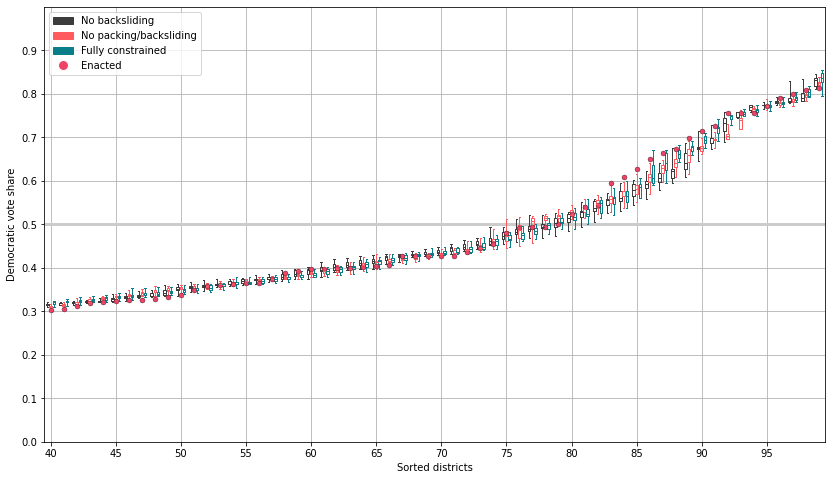

(2021-05-22 21:37:50.886464) Finished.


In [22]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

print("({}) Started.".format(datetime.now()))

start = 39

fig, ax = plt.subplots(figsize=(14, 8))
ax.axhline(0.5, color="#cccccc", linewidth=3)
# ax.axhline(0.37, color="#cccccc", linestyle='--', linewidth=1) # only for bvap

include = [2, 3, 4]
# include = [0, 1, 5]
n = len(include)
for c, i in enumerate(include):
    chain_df = pd.DataFrame(
#         sorted({k: partition['BVAP'][k] / partition['totVAP'][k] for k in partition['totVAP']}.values())[start:] # bvap
        sorted(partition[election]['percents'])[start:] # dem
        for partition in ensembles[i]
    )
    
    box_width = 3/4
    init_pos = box_width*(1/(2*n)-1/2)

    chain_df.boxplot(
        ax=ax, 
        positions=np.arange(init_pos + c*box_width/n, len(chain_df.columns) + init_pos, 1), 
        showfliers=False, 
        whis=[1, 99], 
        color=box_colors[c], 
        widths=box_width/n - .05
    ).set_label(labels[i])

# Plot initial plan
plt.plot(
#     sorted({k: initial['BVAP'][k] / initial['totVAP'][k] for k in initial['totVAP']}.values())[start:], # bvap
    sorted(initial[election]['percents'])[start:], # dem
    color=dot_color, marker='o', linestyle='', markeredgecolor='black', markeredgewidth=0.3,
    markersize=5
)

# Annotate
# ax.set_title("Comparing the 2011 plan to an ensemble")
# ax.set_ylabel("BVAP proportion") # bvap
ax.set_ylabel("Democratic vote share") # dem
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1, 0.1))
ax.set_xlim(-0.5, 98.5 - start)
ax.set_xticks(np.arange(0, 98 - start, 5))
ax.set_xticklabels(np.arange(start + 1, 99, 5))

plt.legend(handles=[mpatches.Patch(color=box_colors[c], label=labels[i]) for c, i in enumerate(include)] + \
                   [Line2D([0], [0], marker='o', markerfacecolor=dot_color, label=labels[-1], markersize=10, color='w')]
          )

plt.show()

print("({}) Finished.".format(datetime.now()))

(2021-05-22 21:25:15.323873) Started.


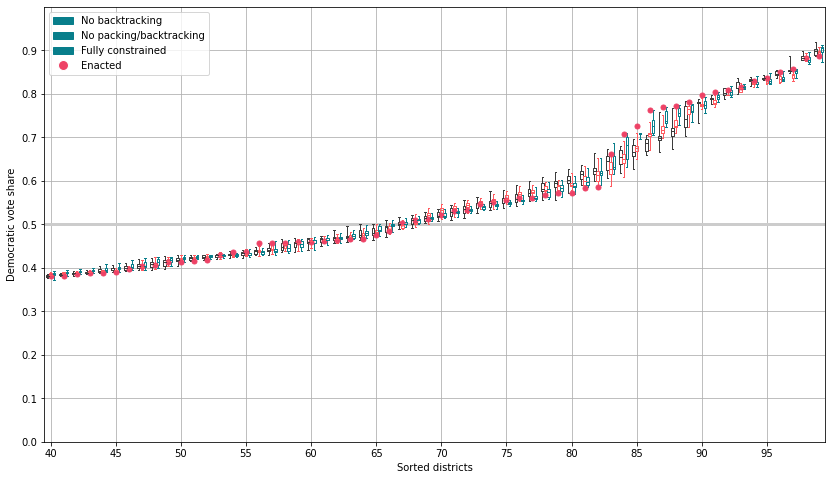

(2021-05-22 21:25:19.030405) Finished.


In [15]:
print("({}) Started.".format(datetime.now()))

start = 39

fig, ax = plt.subplots(figsize=(14, 8))
ax.axhline(0.5, color="#cccccc", linewidth=3)
# ax.axhline(0.37, color="#cccccc", linestyle='--', linewidth=1) # bvap only

include = [2, 3, 4]
n = len(include)
for c, i in enumerate(include):
    chain_df = pd.DataFrame(
#         sorted({k: partition['BVAP'][k] / partition['totVAP'][k] for k in partition['totVAP']}.values())[start:] # bvap
        sorted(partition[election]['percents'])[start:] # dem
        for partition in ensembles[i]
    )
    
    box_width = 3/4
    init_pos = box_width*(1/(2*n)-1/2)

    chain_df.boxplot(
        ax=ax, 
        positions=np.arange(init_pos + c*box_width/n, len(chain_df.columns) + init_pos, 1), 
        showfliers=False, 
        whis=[1, 99], 
        color=box_colors[c], 
        widths=box_width/n - .05
    ).set_label(labels[i])

# Plot initial plan
plt.plot(
#     sorted({k: initial['BVAP'][k] / initial['totVAP'][k] for k in initial['totVAP']}.values())[start:], # bvap
    sorted(initial[election]['percents'])[start:], # dem
    color=dot_color, marker='o', linestyle='',
    markersize=5
)

# Annotate
# ax.set_title("Comparing the 2011 plan to an ensemble")
# ax.set_ylabel("BVAP proportion") # bvap
ax.set_ylabel("Democratic vote share") # dem
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1, 0.1))
ax.set_xlim(-0.5, 98.5 - start)
ax.set_xticks(np.arange(0, 98 - start, 5))
ax.set_xticklabels(np.arange(start + 1, 99, 5))

plt.legend(handles=[mpatches.Patch(color=box_colors[c], label=labels[i]) for i in include] + \
                   [Line2D([0], [0], marker='o', markerfacecolor=dot_color, label=labels[-1], markersize=10, color='w')]
          )

plt.show()

print("({}) Finished.".format(datetime.now()))

(2021-05-01 20:51:21.651651) Started.


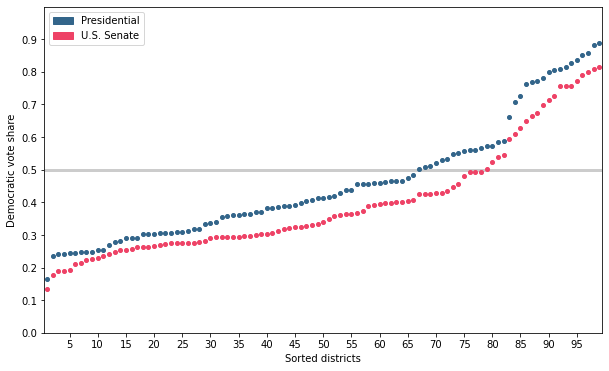

(2021-05-01 20:51:21.971759) Finished.


In [320]:
print("({}) Started.".format(datetime.now()))

fig, ax = plt.subplots(figsize=(10, 6))
ax.axhline(0.5, color="#cccccc", linewidth=3)
# ax.axhline(0.37, color="#cccccc", linestyle='--', linewidth=1) # bvap only

# Plot initial plan
plt.plot(
    sorted(initial['PRES16']['percents']),
    color=box_colors[5], marker='o', linestyle='',
    markersize=4
)

plt.plot(
    sorted(initial['SEN16']['percents']),
    color=dot_color, marker='o', linestyle='',
    markersize=4
)

# Annotate
# ax.set_title("Comparing the 2011 plan to an ensemble")
# ax.set_ylabel("BVAP proportion") # bvap
ax.set_ylabel("Democratic vote share") # dem
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1, 0.1))
ax.set_xlim(-0.5, 98.5)
ax.set_xticks(np.arange(4, 98, 5))
ax.set_xticklabels(np.arange(5, 99, 5))

plt.legend(
    handles=[mpatches.Patch(color=box_colors[5], label='Presidential'), mpatches.Patch(color=dot_color, label='U.S. Senate')]
)

plt.show()

print("({}) Finished.".format(datetime.now()))

## Plot histograms of statistics

7.4835
7.26
10.183
10.086
12.0
12.033


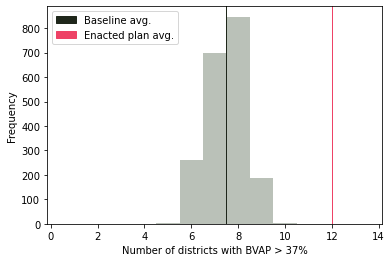

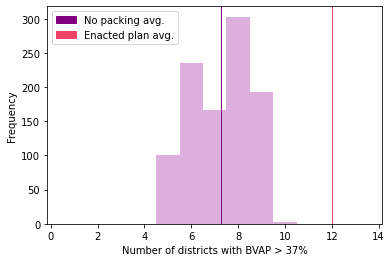

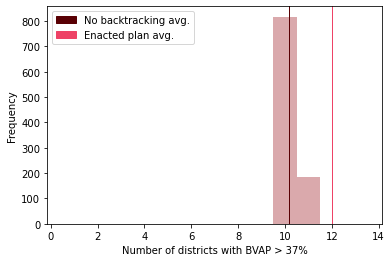

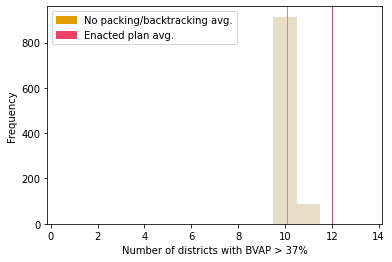

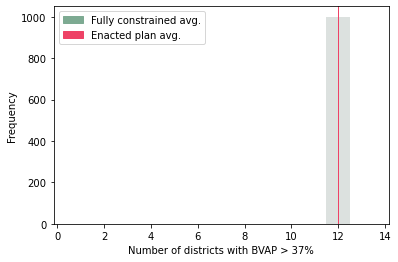

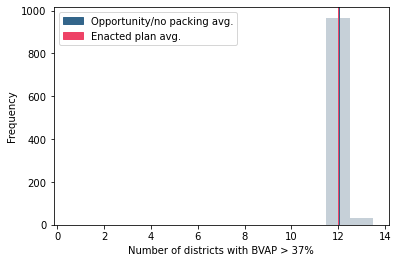

In [283]:
def num_50plus_bvap_districts(partition):
    pct_bvap = np.array(list(partition['BVAP'].values())) / np.array(list(partition['totVAP'].values()))
    df = pd.DataFrame({'BVAP': pct_bvap, 'PRES16': list(partition['PRES16']['percents'])})
    cond = (df['BVAP'] > 0.37) & (df['PRES16'] >= 0.5)
    return cond.sum()

for i in range(len(ensembles)):
    data = [num_50plus_bvap_districts(partition) for partition in ensembles[i]]
    
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.axvline(np.mean(data), color=box_colors[i], linewidth=1)
    ax.axvline(num_50plus_bvap_districts(full_ensembles[i][0]), color=dot_color, linewidth=1)
    
    plt.hist(
        data,
        bins=np.arange(0.5, 14.5, 1), # pres
#         bins=np.arange(17.5, 28.5, 1), # sen
        color=hist_colors[i],
    )
    
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Number of districts with BVAP > 37%")
    
    plt.legend(handles=[mpatches.Patch(color=box_colors[i], label=labels[i]+' avg.'),
                        mpatches.Patch(color=dot_color, label='Enacted plan avg.')] 
    )
    
    print(np.mean(data))

23.7345
1.1506562258120363
z = -2.376469999169579
22.588
1.5324020360205737
z = -1.0362815779883765
20.899
1.4466509599761788
z = 0.0698164262108271
22.601
1.026547125075123
z = -1.5595971786320453
21.154
0.9789198128549652
z = -0.157316256119965
22.858
0.8920964073462015
z = -2.082734539338812


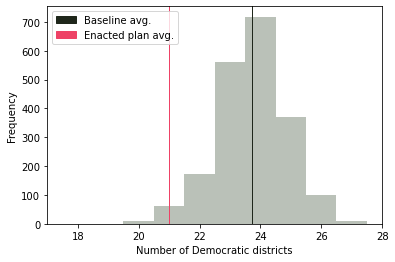

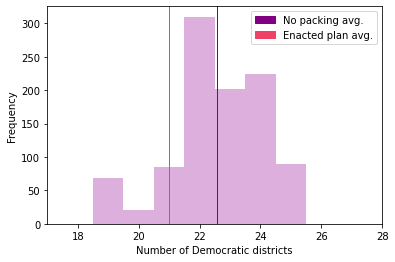

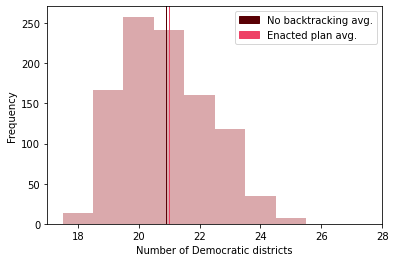

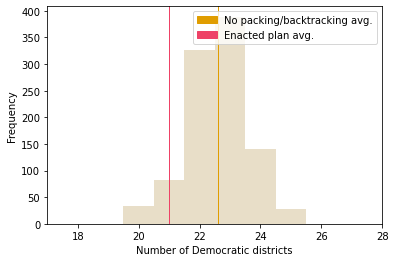

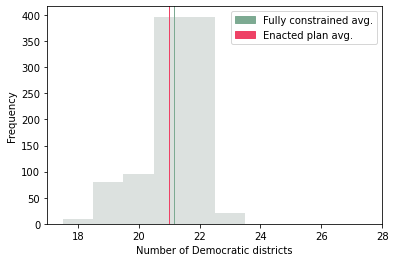

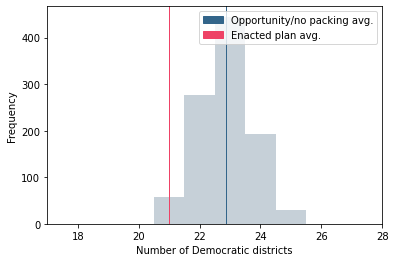

In [311]:
for i in range(len(ensembles)):
    data = [partition[election]['wins'] for partition in ensembles[i]]
    initial_val = full_ensembles[i][0][election]['wins']
    
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.axvline(np.mean(data), color=box_colors[i], linewidth=1)
    ax.axvline(initial_val, color=dot_color, linewidth=1)
    
    plt.hist(
        data,
#         bins=np.arange(28.5, 39.5, 1), # pres
        bins=np.arange(17.5, 28.5, 1), # sen
        color=hist_colors[i],
    )
    
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Number of Democratic districts")
    
    plt.legend(handles=[mpatches.Patch(color=box_colors[i], label=labels[i]+' avg.'),
                        mpatches.Patch(color=dot_color, label='Enacted plan avg.')] 
    )
    
    print(np.mean(data))
    print(np.std(data))
    print('z =', (initial_val - np.mean(data))/np.std(data))

-0.03315973667422263
0.004555767624233004
z = -2.824222005010077
-0.032135506065550073
0.003860259612049292
z = -3.5983926416207357
-0.03970382677049756
0.006496977958424215
z = -0.9731307568311109
-0.03749469376651207
0.0036385048254057154
z = -2.34479339486119
-0.03762921677015427
0.003648659388255492
z = -2.30139845477725
-0.0391005255645813
0.004471468295090781
z = -1.5488671341618114


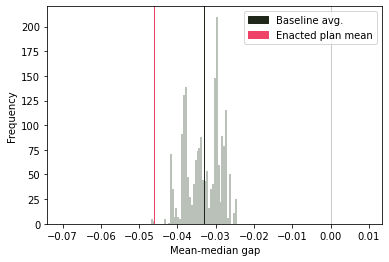

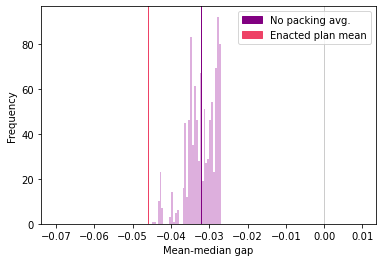

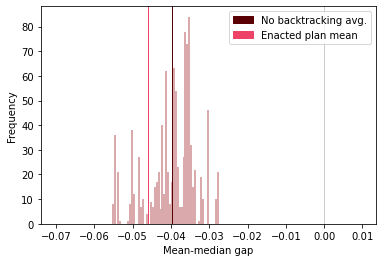

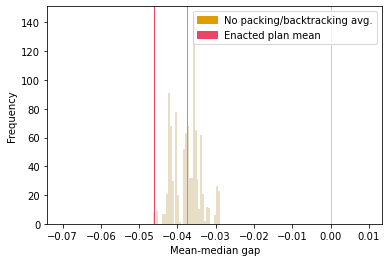

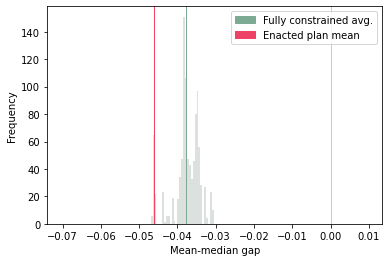

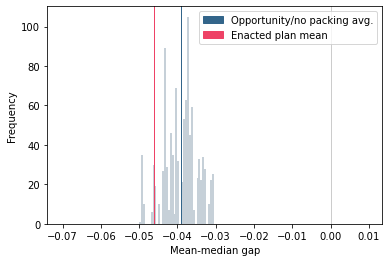

In [326]:
for i in range(len(ensembles)):
    data = [partition[election]['mean_median'] for partition in ensembles[i]]
    initial_val = full_ensembles[i][0][election]['mean_median']
    
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.axvline(0, color='#cccccc', linewidth=1)
    ax.axvline(np.mean(data), color=box_colors[i], linewidth=1)
    ax.axvline(initial_val, color=dot_color, linewidth=1)
    
    plt.hist(
        data,
        bins=np.arange(-0.07, 0.01, 0.0005),
        color=hist_colors[i],
    )
    
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Mean-median gap")
    
    plt.legend(handles=[mpatches.Patch(color=box_colors[i], label=labels[i]+' avg.'),
                        mpatches.Patch(color=dot_color, label='Enacted plan mean')] 
    )
    
    print(np.mean(data))
    print(np.std(data))
    print('z =', (initial_val - np.mean(data))/np.std(data))

-0.0770507739024922
-0.07074025375117518
-0.08534854384864357
-0.0896706586179201
-0.08354596943335538
-0.08229154621410949


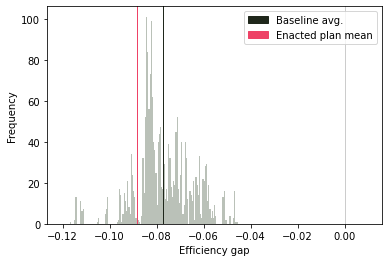

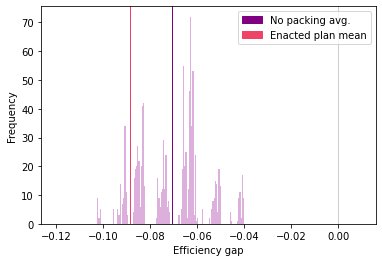

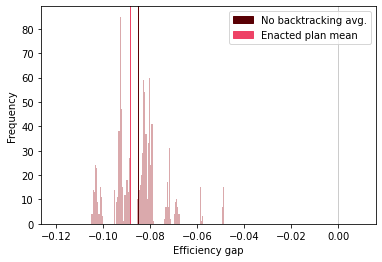

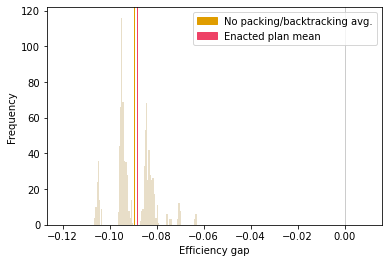

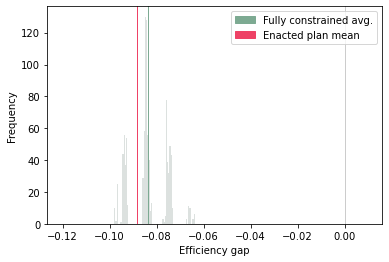

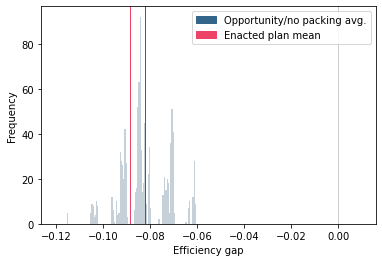

In [299]:
for i in range(len(ensembles)):
    data = [partition[election]['efficiency_gap'] for partition in ensembles[i]]
    
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.axvline(0, color='#cccccc', linewidth=1)
    ax.axvline(np.mean(data), color=box_colors[i], linewidth=1)
    ax.axvline(full_ensembles[i][0][election]['efficiency_gap'], color=dot_color, linewidth=1)
    
    plt.hist(
        data,
        bins=np.arange(-0.12, 0.01, 0.0005),
        color=hist_colors[i],
    )
    
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Efficiency gap")
    
    plt.legend(handles=[mpatches.Patch(color=box_colors[i], label=labels[i]+' avg.'),
                        mpatches.Patch(color=dot_color, label='Enacted plan mean')] 
    )
    
    print(np.mean(data))

-0.014499213810609327
0.008361533348226915
z = -1.6585674830059338
-0.007728913451759276
0.009316087025398937
z = -2.215357974010033
-0.02377992108414901
0.00781739542881115
z = -0.5868271712330227
-0.026605393329024857
0.005948377132207613
z = -0.29621319594600715
-0.024710836380621985
0.0057652172109033594
z = -0.6342423217829264
-0.020315038169160495
0.007958496988315382
z = -1.0117919216040574


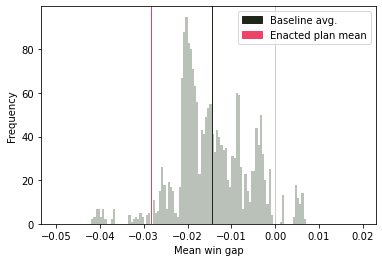

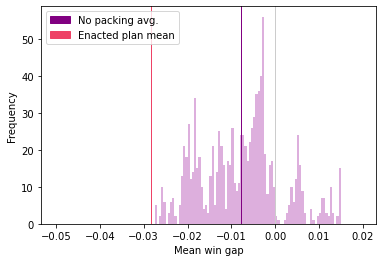

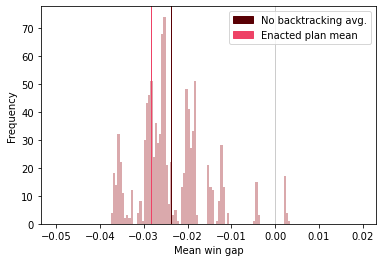

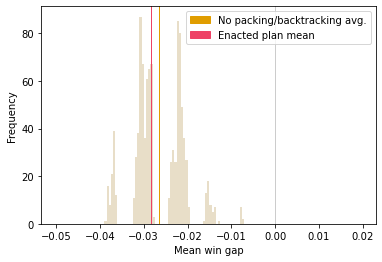

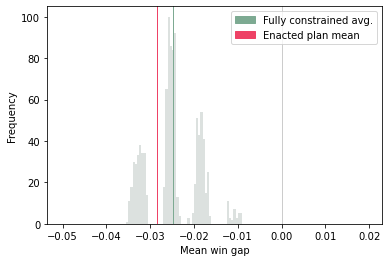

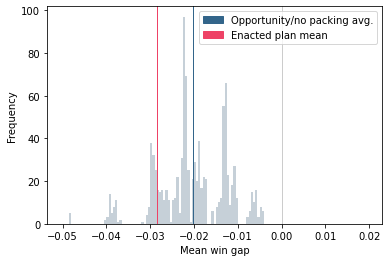

In [329]:
election = 'PRES16'

def mean_win_gap(dem_pcts):
    dem_pcts = np.array(dem_pcts)
    dem_wins = np.delete(dem_pcts, np.where(dem_pcts < 0.5))
    rep_wins = 1 - np.delete(dem_pcts, np.where(dem_pcts >= 0.5))
    return np.mean(rep_wins) - np.mean(dem_wins)

for i in range(len(ensembles)):
    data = [mean_win_gap(partition[election]['percents']) for partition in ensembles[i]]
    initial_val = mean_win_gap(full_ensembles[i][0][election]['percents'])
    
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.axvline(0, color='#cccccc', linewidth=1)
    ax.axvline(np.mean(data), color=box_colors[i], linewidth=1)
    ax.axvline(initial_val, color=dot_color, linewidth=1)
    
    plt.hist(
        data,
        bins=np.arange(-0.05, 0.02, 0.0005),
        color=hist_colors[i],
    )
    
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Mean win gap")
    
    plt.legend(handles=[mpatches.Patch(color=box_colors[i], label=labels[i]+' avg.'),
                        mpatches.Patch(color=dot_color, label='Enacted plan mean')] 
    )
    
    print(np.mean(data))
    print(np.std(data))
    print('z =', (initial_val - np.mean(data))/np.std(data))

0.049488990637004404
0.04377473661200645
0.015003924963055429
0.028241199629172705
0.00876934696445372
0.03538658111726892


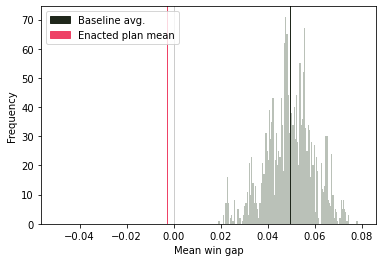

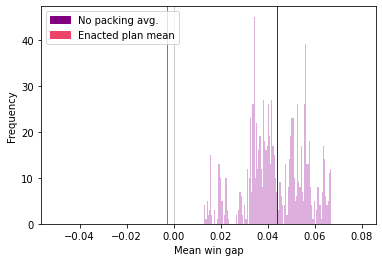

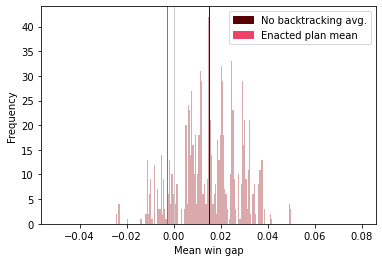

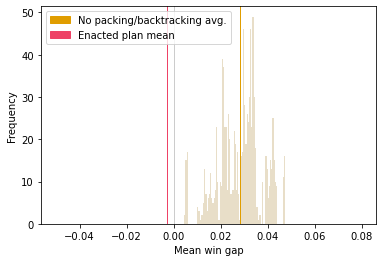

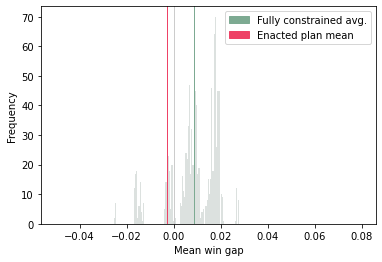

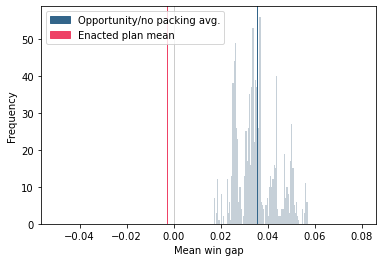

In [316]:
election = 'SEN16'

for i in range(len(ensembles)):
    data = [mean_win_gap(partition[election]['percents']) for partition in ensembles[i]]
    
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.axvline(0, color='#cccccc', linewidth=1)
    ax.axvline(np.mean(data), color=box_colors[i], linewidth=1)
    ax.axvline(mean_win_gap(full_ensembles[i][0][election]['percents']), color=dot_color, linewidth=1)
    
    plt.hist(
        data,
        bins=np.arange(-0.05, 0.08, 0.0005),
        color=hist_colors[i],
    )
    
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Mean win gap")
    
    plt.legend(handles=[mpatches.Patch(color=box_colors[i], label=labels[i]+' avg.'),
                        mpatches.Patch(color=dot_color, label='Enacted plan mean')] 
    )
    
    print(np.mean(data))

-0.097510101010101
-0.08995959595959596
-0.09918181818181819
-0.09868686868686871
-0.09663636363636365
-0.11394949494949495


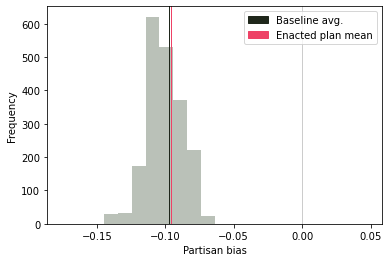

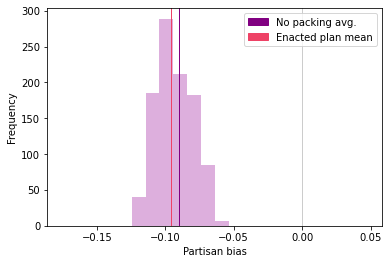

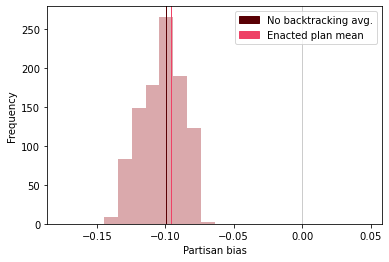

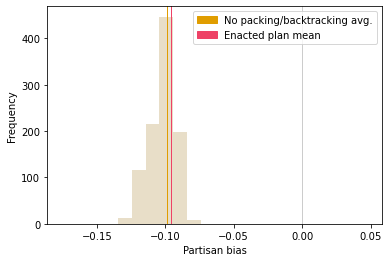

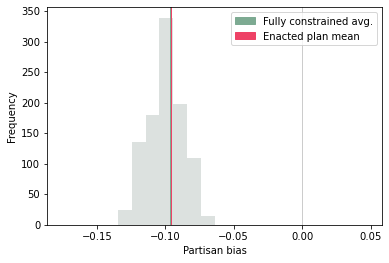

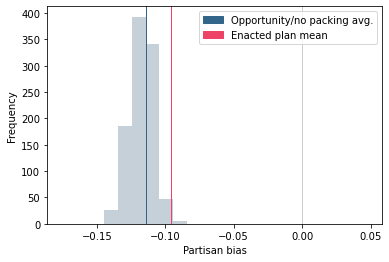

In [301]:
for i in range(len(ensembles)):
    data = [partition[election]['partisan_bias'] for partition in ensembles[i]]
    
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.axvline(0, color='#cccccc', linewidth=1)
    ax.axvline(np.mean(data), color=box_colors[i], linewidth=1)
    ax.axvline(full_ensembles[i][0][election]['partisan_bias'], color=dot_color, linewidth=1)
    
    plt.hist(
        data,
        bins=np.arange(-0.175, 0.05, 1/99),
        color=hist_colors[i],
    )
    
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Partisan bias")
    
    plt.legend(handles=[mpatches.Patch(color=box_colors[i], label=labels[i]+' avg.'),
                        mpatches.Patch(color=dot_color, label='Enacted plan mean')] 
    )
    
    print(np.mean(data))

In [323]:
data = [partition['SEN16']['wins'] for partition in ensembles[0]]
np.bincount(data)

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   8,  63, 172, 561, 718, 369,
       101,   8], dtype=int64)

In [328]:
np.std(initial['PRES16']['percents'])

0.1822221072003581

In [330]:
full_ensembles[i][0][election]['mean_median']

-0.04602623584829396

In [337]:
for i in range(6):
    for j in range(len(ensembles[i])):
        dem_pcts = np.array(ensembles[i][j][election]['percents'])
        dem_wins = np.delete(dem_pcts, np.where(dem_pcts < 0.5))
        rep_wins = 1 - np.delete(dem_pcts, np.where(dem_pcts >= 0.5))
        p = st.ttest_ind(dem_wins, rep_wins, equal_var=False).pvalue
        if p < .05:
            print('{}, {}: p = {}'.format(i, j, p))

5, 598: p = 0.039962531370994474
5, 599: p = 0.040239913800816055
5, 600: p = 0.0400516934935438
5, 601: p = 0.040102040360564285
5, 602: p = 0.040036983333844034
